## Finding Nearest Neighbours on videos using feature mode

In [2]:
import tensorflow as tf
import PIL
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Dropout, Dense, Softmax)
from tensorflow.keras.applications import mobilenet as _mobilenet
import random
import os
import numpy as np

In [3]:
import json
import os
from moviepy.editor import *
from moviepy import *
import shutil
import numpy as np
import cv2
import tempfile

In [4]:
import matplotlib.pyplot as plt

In [5]:
from PIL import Image

In [6]:
import networkx as nx
from sklearn.neighbors import NearestNeighbors

In [7]:
from IPython.display import Image as iImage
from IPython.display import display

In [8]:
def load_image(img_file, target_size=(224,224)):
    X = np.zeros((1, *target_size, 3))
    X[0, ] = np.asarray(tf.keras.preprocessing.image.load_img(
        img_file, 
        target_size=target_size)
    )
    X = tf.keras.applications.mobilenet.preprocess_input(X)
    return X

def ensure_folder_exists(folder):
    if not os.path.exists(folder):
        os.makedirs(folder)

In [9]:
model = tf.keras.applications.mobilenet.MobileNet(
# The 3 is the three dimensions of the input: r,g,b.
  input_shape=(224, 224, 3), 
  include_top=False, 
  pooling='avg'
)

2023-02-09 09:15:53.369055: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [121]:
videos = os.listdir('/Users/mansikothari/Documents/UD_MARCH/RC_11/Skills_Class/SkillsClasses_Assignment/01_Julian/04_DesignAlgorithms/trial')

In [122]:
videos

['fragment03.mp4', 'fragment02.mp4', 'fragment01.mp4', 'fragment04.mp4']

In [123]:
videos.sort(key = lambda x : (x.split('.')[0]))

In [124]:
videos = list(filter(lambda x: x != ".DS_Store", videos))

In [125]:
videos

['fragment01.mp4', 'fragment02.mp4', 'fragment03.mp4', 'fragment04.mp4']

In [89]:
def process_image(image_path, model):
    # Load the image using OpenCV
    image = cv2.imread(image_path)

    # Pre-process the image for the model
    # You can add your own pre-processing steps here
    image = cv2.resize(image, (224,224))
    image = np.expand_dims(image, axis=0)

    # Use the model to predict the features for the image
    features = model.predict(image)

    # Return the features
    return features

In [90]:
import os
import cv2
import tempfile

def process_video(video_path, model):
    # Open the video using OpenCV
    cap = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Create a list to store the features for each frame
    features = []

    # Read each frame from the video
    for i in range(total_frames):
        # Read the next frame
        ret, frame = cap.read()

        # If there are no more frames, break the loop
        if not ret:
            break

        # Write the frame to a temporary file
        with tempfile.NamedTemporaryFile(suffix='.jpg') as temp:
            cv2.imwrite(temp.name, frame)
            # Process the temporary image file
            f = process_image(temp.name, model)

        # Append the features for the current frame to the list
        features.append(f[0].flatten())

    # Release the video capture object
    cap.release()

    # Return the features for all the frames in the video
    return features

In [91]:
video_dir = '/Users/mansikothari/Documents/UD_MARCH/RC_11/Skills_Class/SkillsClasses_Assignment/01_Julian/04_DesignAlgorithms/trial'
videos = os.listdir(video_dir)

In [92]:
all_filenames = []
all_features = []
for video in videos:
    video_path = os.path.join(video_dir, video)
    features = process_video(video_path, model)
    all_features.append(features)
    all_filenames.append(video)

In [94]:
all_features

[[array([0.0000000e+00, 1.3865727e+00, 1.4066696e-03, ..., 1.4092758e+00,
         0.0000000e+00, 0.0000000e+00], dtype=float32),
  array([0.       , 1.3678344, 0.       , ..., 1.4535782, 0.       ,
         0.       ], dtype=float32),
  array([0.00435356, 1.2754112 , 0.05068256, ..., 1.2324463 , 0.        ,
         0.        ], dtype=float32),
  array([0.        , 1.0065154 , 0.22142586, ..., 1.1258235 , 0.        ,
         0.04006405], dtype=float32),
  array([0.00362809, 1.4271336 , 0.00880012, ..., 1.3367667 , 0.        ,
         0.00800548], dtype=float32),
  array([0.        , 1.1264946 , 0.00198239, ..., 0.9762437 , 0.        ,
         0.07822203], dtype=float32),
  array([0.        , 1.1353483 , 0.01857757, ..., 1.1651831 , 0.        ,
         0.14297608], dtype=float32),
  array([0.        , 0.7084911 , 0.06132684, ..., 0.84090394, 0.        ,
         0.        ], dtype=float32),
  array([0.        , 0.7367342 , 0.11047668, ..., 0.49156836, 0.        ,
         0.       

In [95]:
all_features = np.array(all_features)
all_features = all_features.reshape(all_features.shape[0] * all_features.shape[1], all_features.shape[2])
nbrs = NearestNeighbors(n_neighbors=3, algorithm='auto').fit(all_features)

# Find the nearest neighbors for each feature
distances, indices = nbrs.kneighbors(all_features)


In [96]:
indices

array([[  0,   1,   2],
       [  1,   0,   2],
       [  2,   3,   0],
       ...,
       [477, 479, 474],
       [478, 479, 477],
       [479, 478, 477]])

In [97]:
len(indices)

480

In [98]:
len(videos)

4

In [99]:
from ipywidgets import Video

In [100]:
def showNearestNeighbours(index, indices, videos, path):
    for i in indices[index]:
        f = videos[i]
        print(f)
        display(Video(filename = os.path.join(path, f)))

In [101]:
showNearestNeighbours(2, indices, videos, '/Users/mansikothari/Documents/UD_MARCH/RC_11/Skills_Class/SkillsClasses_Assignment/01_Julian/04_DesignAlgorithms/trial')

fragment01.mp4


Video(value=b'')

fragment04.mp4


Video(value=b'')

fragment03.mp4


Video(value=b'')

In [102]:
distances

array([[0.        , 0.59761524, 8.152073  ],
       [0.        , 0.59761524, 8.191174  ],
       [0.        , 7.50948   , 8.152073  ],
       ...,
       [0.        , 7.721308  , 8.075564  ],
       [0.        , 7.5011654 , 8.237171  ],
       [0.        , 7.5011654 , 7.721308  ]], dtype=float32)

In [103]:
G = nx.Graph()

In [104]:
for i in videos:
    G.add_node(i)

In [133]:
def createEdges(indices, files, distances):
    weightedEdges = []
    for i in range(len(indices)):
        index = indices[i]
        dist = distances[i][1:]
        
        node = i
        
        edges = []
        for e in index[1:]:
            edges.append(e)
        
        for i in range(len(edges)):
            weightedEdges.append((node, edges[i], dist[i]))
    
    return weightedEdges

In [134]:
edges = createEdges(indices, all_filenames, distances)

In [135]:
edges

[(0, 1, 0.59761524),
 (0, 2, 8.152073),
 (1, 0, 0.59761524),
 (1, 2, 8.191174),
 (2, 3, 7.50948),
 (2, 0, 8.152073),
 (3, 2, 7.50948),
 (3, 1, 9.677276),
 (4, 6, 8.524827),
 (4, 2, 8.794517),
 (5, 6, 7.477119),
 (5, 8, 8.606307),
 (6, 5, 7.477119),
 (6, 7, 8.323587),
 (7, 9, 7.721918),
 (7, 8, 7.7552023),
 (8, 9, 6.8565154),
 (8, 7, 7.7552023),
 (9, 8, 6.8565154),
 (9, 10, 7.4935417),
 (10, 9, 7.4935417),
 (10, 8, 7.990999),
 (11, 12, 7.903498),
 (11, 10, 8.215109),
 (12, 13, 7.1513534),
 (12, 11, 7.903498),
 (13, 12, 7.1513534),
 (13, 14, 8.50135),
 (14, 15, 7.222275),
 (14, 9, 8.178106),
 (15, 14, 7.222275),
 (15, 16, 7.558893),
 (16, 15, 7.558893),
 (16, 17, 8.727567),
 (17, 21, 8.152279),
 (17, 16, 8.727567),
 (18, 19, 8.448491),
 (18, 17, 9.462293),
 (19, 18, 8.448491),
 (19, 20, 8.555802),
 (20, 21, 7.482054),
 (20, 22, 8.397316),
 (21, 20, 7.482054),
 (21, 17, 8.152279),
 (22, 20, 8.397316),
 (22, 23, 8.715266),
 (23, 22, 8.715266),
 (23, 24, 8.748524),
 (24, 23, 8.748524),
 (24

In [136]:
G.add_weighted_edges_from(edges)

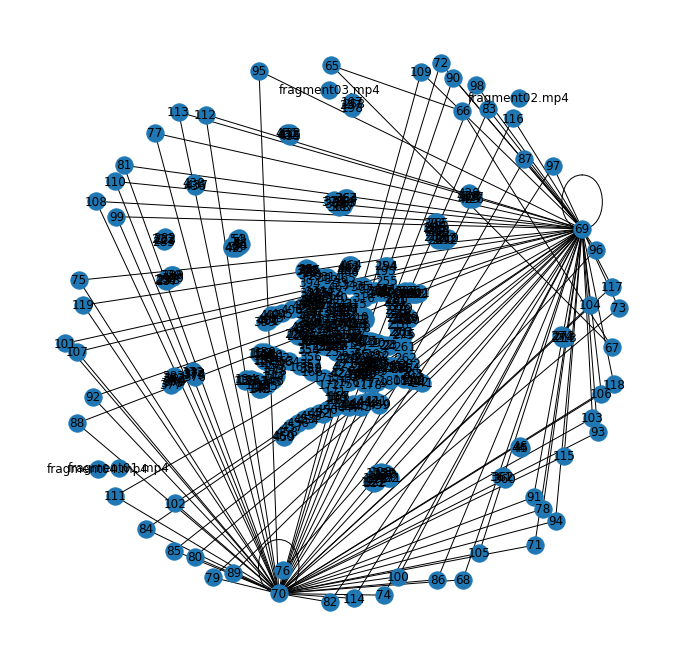

In [137]:
fig, ax = plt.subplots(figsize = (12,12))
nx.draw(G, with_labels=True)

In [138]:
T = nx.minimum_spanning_tree(G)

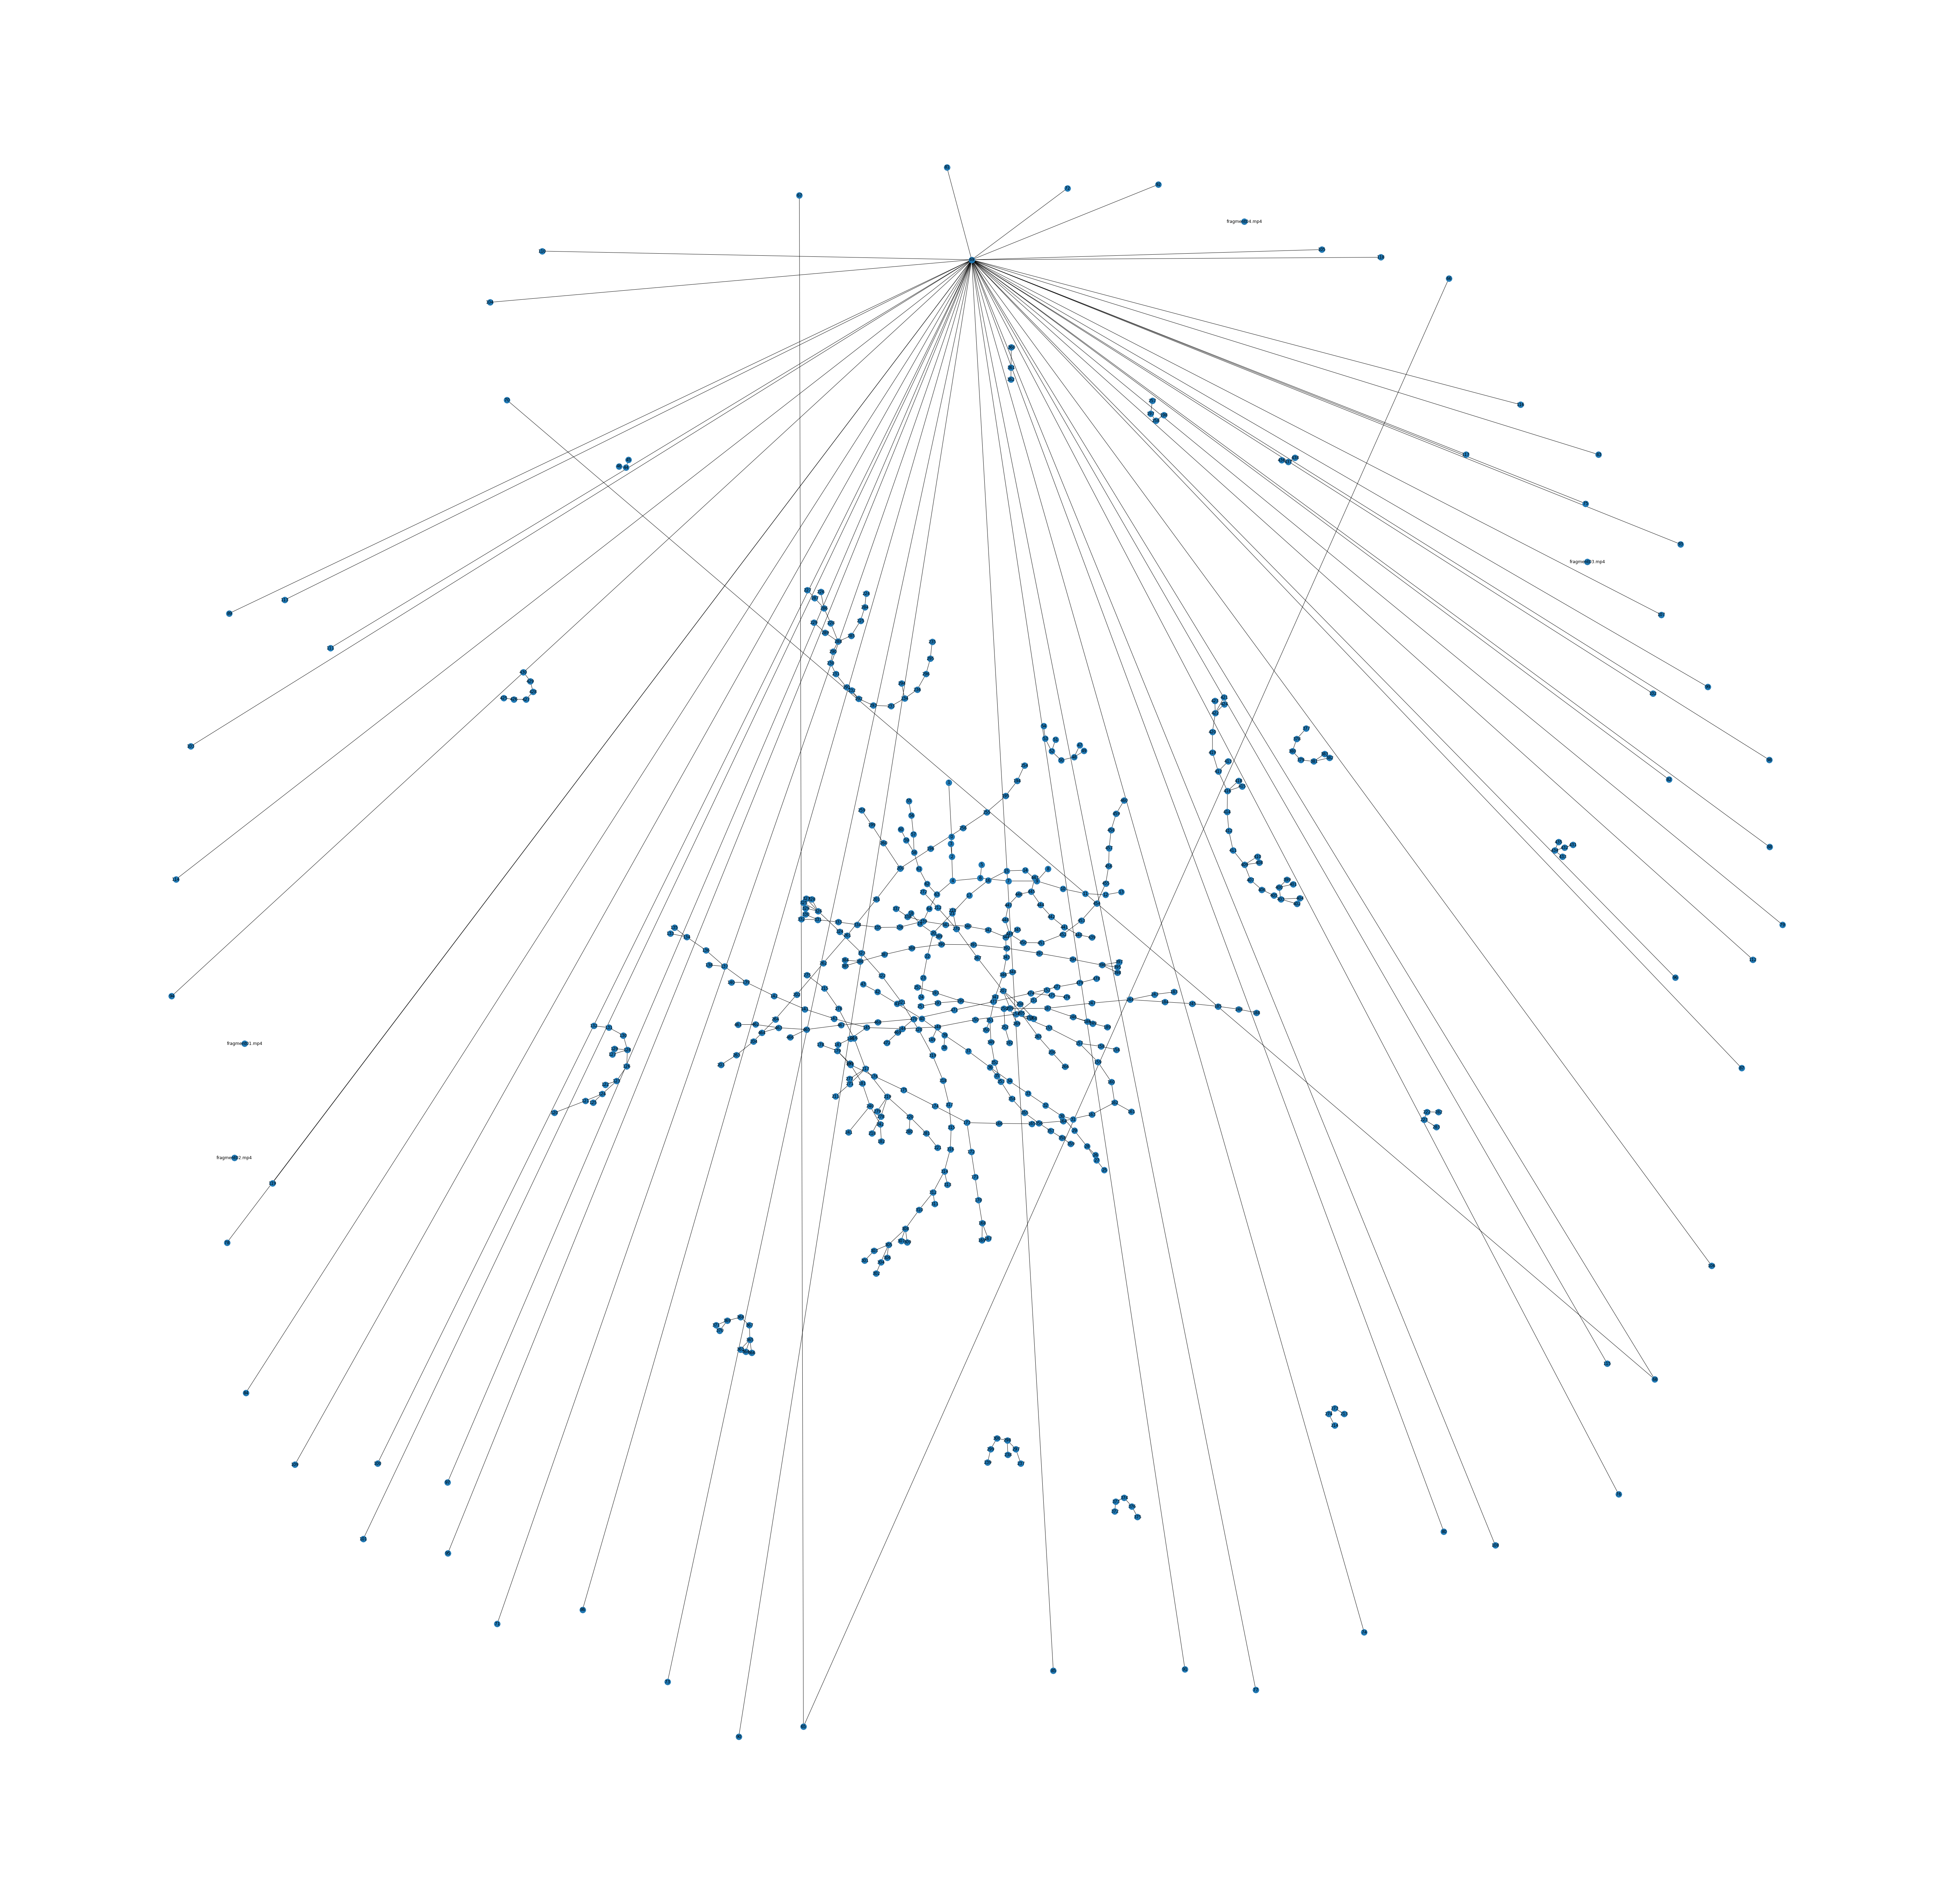

In [139]:
fig, ax = plt.subplots(figsize = (100,100))
nx.draw(T,with_labels=True)